# 任务框架图

## 数据集展示

### SMAP缺失率图绘制

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import geopandas as gpd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)

def generate_clipping_mask(lon_grid, lat_grid, shp_path):
    """
    使用.shp文件生成数据掩码：在边界外的数据掩码为0，在边界内的数据掩码为1。
    """
    import geopandas as gpd
    from shapely.geometry import Point
    import numpy as np

    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    mask = np.zeros_like(lon_grid, dtype=bool)

    for i in range(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                mask[i, j] = True

    return mask

def add_north(ax, labelsize=12, loc_x=0.05, loc_y=0.96, width=0.03, height=0.15, pad=0.15):
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.add_patch(triangle)

def add_scalebar(ax,lon0,lat0,length,size=0.45,lw=1.5):
    # style 3
    lw = lw
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=lw, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=lw)
    ax.text(lon0+length/111,lat0+size+0.12,'%d' % (length),horizontalalignment = 'center',size=18)
    ax.text(lon0+length/2/111,lat0+size+0.12,'%d' % (length/2),horizontalalignment = 'center',size=18)
    ax.text(lon0,lat0+size+0.12,'0',horizontalalignment = 'center',size=18)
    ax.text(lon0+length/111/2*2.30,lat0+size+0.12,'km',horizontalalignment = 'center',size=18)

def custom_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        str_x = "{:.15g}".format(x)
        if 'e' in str_x:
            base, exponent = str_x.split('e')
            base = base.rstrip('0').rstrip('.')
            exponent = exponent.replace('+', '').lstrip('0')
            if exponent:
                return f"{base}e{exponent}"
            else:
                return base
        else:
            return str_x
        
def add_degree_E(x, pos):
    return f"{int(x)}°E"

def add_degree_N(y, pos):
    return f"{int(custom_formatter(y, pos))}°N"

# SHP地址
shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
lakes_path = r"D:\Data_Store\TPBoundary_new(2021)\Lake_TP_2010.shp"
tp_boundary = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)

# SMAP数据
SMAP_file_path = r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy"
dates = pd.date_range(start='2016-01-01 03:00', periods=8768, freq='3H')
filter_mask = ((dates.hour == 6) | (dates.hour == 18))
filtered_indices = np.where(filter_mask)[0]
SMAP_data = np.load(SMAP_file_path)[filtered_indices, :, :]


nan_counts = np.isnan(SMAP_data).sum(axis=(0))
zero_counts = (SMAP_data == 0).sum(axis=(0))
total_pixels_per_time_step = SMAP_data.shape[0]
missing_rate = (nan_counts + zero_counts) / total_pixels_per_time_step

# 掩码运算
settings = {0.37: (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)}
masks = {}
for mode, (lat_min, lat_max, lon_min, lon_max, lat_points, lon_points) in settings.items():
    lon_range, lat_range = np.linspace(lon_min, lon_max, lon_points), np.linspace(lat_min, lat_max, lat_points)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    masks = generate_clipping_mask(lon_grid, lat_grid, shp_path)
mask = masks
clip_missing_rate = np.where(mask, missing_rate, np.nan)

# 创建地图热力图
low_res_params = (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)
num_lons = low_res_params[4]
num_lats = low_res_params[5]
lon_step = (low_res_params[3] - low_res_params[2]) / (num_lons - 1)
lat_step = (low_res_params[1] - low_res_params[0]) / (num_lats - 1)

lon_min_adj = low_res_params[2] - lon_step / 2
lon_max_adj = low_res_params[3] + lon_step / 2
lat_min_adj = low_res_params[0] - lat_step / 2
lat_max_adj = low_res_params[1] + lat_step / 2

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# 绘制地理空间数据
gdf = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)
lakes = lakes.to_crs(epsg=4326)
lakes.plot(ax=ax, edgecolor='white', facecolor='white', linewidth=0)
gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

image = ax.imshow(clip_missing_rate, cmap='YlGnBu', origin='lower', vmin=0, vmax=1, extent=[lon_min_adj, lon_max_adj, lat_min_adj, lat_max_adj], aspect='auto')

# 设置X轴和Y轴的标签
ax.set_xlabel('Longitude(°)',size=18)
ax.set_ylabel('Latitude(°)',size=18)
ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=18, direction='out', pad=2, bottom=True, top=True, labelbottom=True,labeltop=False)
ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=18, direction='out', pad=6, left=True, right=True, labelleft=True,labelright=False)
plt.setp(ax.get_xticklabels(), rotation=0,rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
# 刻度标签轴绘制
labelsize = 18
pad_x = 4
pad_y = 10
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))

# 刻度调节
plt.setp(ax.get_yticklabels(), rotation=90,ha="center", rotation_mode="anchor")
# 刻度值格式
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax.tick_params(axis='y', which='both', colors='black', length=3, width=1.5, labelsize=labelsize, direction='in', pad=pad_y, right=False, labelright=False)
ax.tick_params(axis='x', which='both', colors='black', length=3, width=1.5, labelsize=labelsize, direction='in', pad=pad_x, top=False, labeltop=False)
add_north(ax)
add_scalebar(ax,67.3,26.3,1000,size=0.4,lw=1.5)
ax.grid(False)

cbar_ax = fig.add_axes([0.98, 0.1, 0.025, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.set_label('Missing rate', size=20)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Administrator\Desktop\Draw\SMAP_Miss_rate_darw.jpeg", dpi=150, format='jpeg', bbox_inches='tight')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20136\1881441488.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


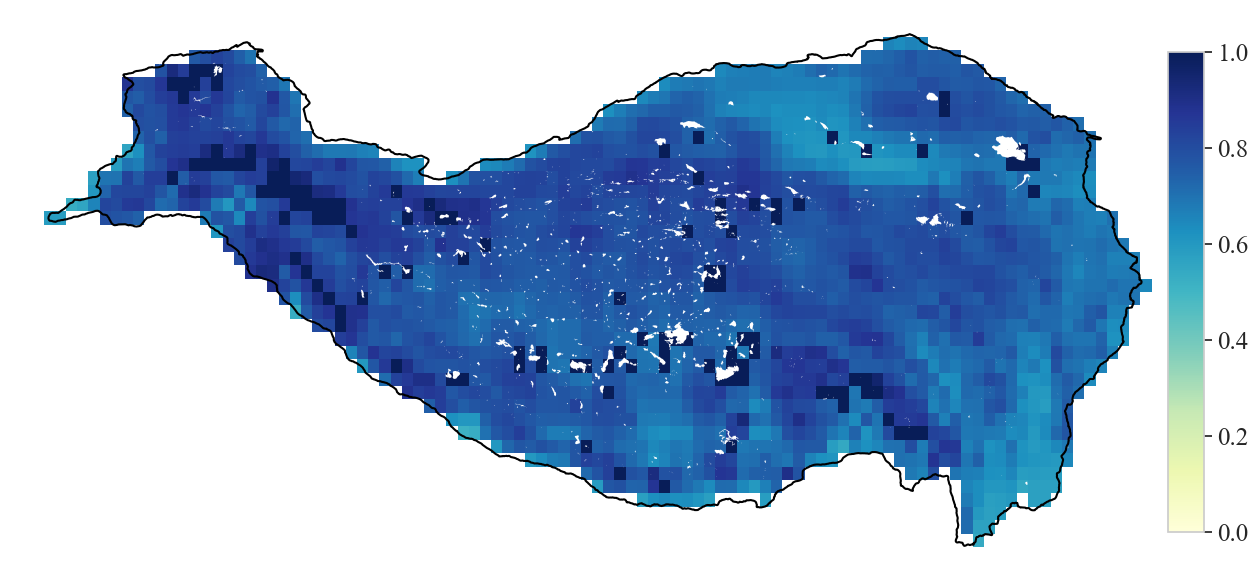

In [64]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import geopandas as gpd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)

def generate_clipping_mask(lon_grid, lat_grid, shp_path):
    """
    使用.shp文件生成数据掩码：在边界外的数据掩码为0，在边界内的数据掩码为1。
    """
    import geopandas as gpd
    from shapely.geometry import Point
    import numpy as np

    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    mask = np.zeros_like(lon_grid, dtype=bool)

    for i in range(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                mask[i, j] = True

    return mask

# SHP地址
shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
lakes_path = r"D:\Data_Store\TPBoundary_new(2021)\Lake_TP_2010.shp"
tp_boundary = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)

# SMAP数据
SMAP_file_path = r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy"
dates = pd.date_range(start='2016-01-01 03:00', periods=8768, freq='3H')
filter_mask = ((dates.hour == 6) | (dates.hour == 18))
filtered_indices = np.where(filter_mask)[0]
SMAP_data = np.load(SMAP_file_path)[filtered_indices, :, :]


nan_counts = np.isnan(SMAP_data).sum(axis=(0))
zero_counts = (SMAP_data == 0).sum(axis=(0))
total_pixels_per_time_step = SMAP_data.shape[0]
missing_rate = (nan_counts + zero_counts) / total_pixels_per_time_step

# 掩码运算
settings = {0.37: (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)}
masks = {}
for mode, (lat_min, lat_max, lon_min, lon_max, lat_points, lon_points) in settings.items():
    lon_range, lat_range = np.linspace(lon_min, lon_max, lon_points), np.linspace(lat_min, lat_max, lat_points)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    masks = generate_clipping_mask(lon_grid, lat_grid, shp_path)
mask = masks
clip_missing_rate = np.where(mask, missing_rate, np.nan)

# 创建地图热力图
low_res_params = (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)
num_lons = low_res_params[4]
num_lats = low_res_params[5]
lon_step = (low_res_params[3] - low_res_params[2]) / (num_lons - 1)
lat_step = (low_res_params[1] - low_res_params[0]) / (num_lats - 1)

lon_min_adj = low_res_params[2] - lon_step / 2
lon_max_adj = low_res_params[3] + lon_step / 2
lat_min_adj = low_res_params[0] - lat_step / 2
lat_max_adj = low_res_params[1] + lat_step / 2

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# 绘制地理空间数据
gdf = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)
lakes = lakes.to_crs(epsg=4326)
lakes.plot(ax=ax, edgecolor='white', facecolor='white', linewidth=0)
gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

image = ax.imshow(clip_missing_rate, cmap='YlGnBu', origin='lower', vmin=0, vmax=1, extent=[lon_min_adj, lon_max_adj, lat_min_adj, lat_max_adj], aspect='auto')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.grid(False)

cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Administrator\Desktop\Draw\SMAP_Miss_rate_darw.png", dpi=150, format='png', bbox_inches='tight', transparent=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20136\1666477269.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


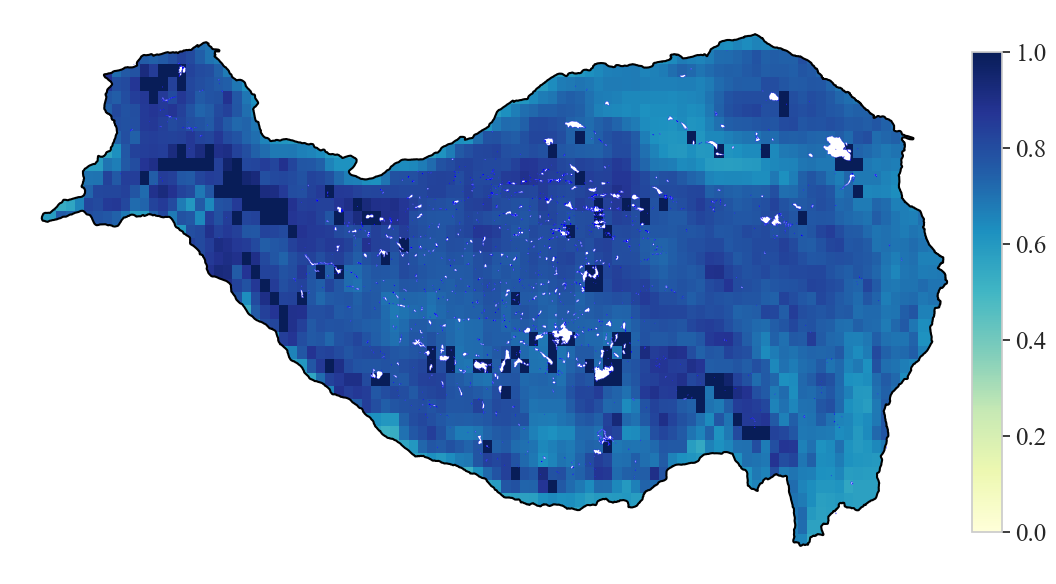

In [67]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib as mpl

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)

# SHP地址
shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
lakes_path = r"D:\Data_Store\TPBoundary_new(2021)\Lake_TP_2010.shp"
tp_boundary = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)

# SMAP数据
SMAP_file_path = r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy"
dates = pd.date_range(start='2016-01-01 03:00', periods=8768, freq='3H')
filter_mask = ((dates.hour == 6) | (dates.hour == 18))
filtered_indices = np.where(filter_mask)[0]
SMAP_data = np.load(SMAP_file_path)[filtered_indices, :, :]


nan_counts = np.isnan(SMAP_data).sum(axis=(0))
zero_counts = (SMAP_data == 0).sum(axis=(0))
total_pixels_per_time_step = SMAP_data.shape[0]
missing_rate = (nan_counts + zero_counts) / total_pixels_per_time_step

# 创建地图热力图
low_res_params = (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)
num_lons = low_res_params[4]
num_lats = low_res_params[5]
lon_step = (low_res_params[3] - low_res_params[2]) / (num_lons - 1)
lat_step = (low_res_params[1] - low_res_params[0]) / (num_lats - 1)

lon_min_adj = low_res_params[2] - lon_step / 2
lon_max_adj = low_res_params[3] + lon_step / 2
lat_min_adj = low_res_params[0] - lat_step / 2
lat_max_adj = low_res_params[1] + lat_step / 2

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# 绘制地理空间数据
gdf = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)
polygons = [Path(np.array(shape.exterior.coords)) for shape in gdf.geometry]
path = Path.make_compound_path(*polygons)
patch = PathPatch(path, facecolor='none', edgecolor='none')
ax.add_patch(patch)
ax.set_clip_path(patch)

lakes = lakes.to_crs(epsg=4326)
lakes.plot(ax=ax, edgecolor='blue', facecolor='white', linewidth=0.2)
gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)


image = ax.imshow(missing_rate, cmap='YlGnBu', origin='lower', vmin=0, vmax=1, extent=[lon_min_adj, lon_max_adj, lat_min_adj, lat_max_adj], aspect='auto', clip_path=patch)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.grid(False)

cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Administrator\Desktop\Draw\SMAP_Miss_rate_darw.png", dpi=150, format='png', bbox_inches='tight', transparent=True)

### 辅助变量绘图
使用三维图

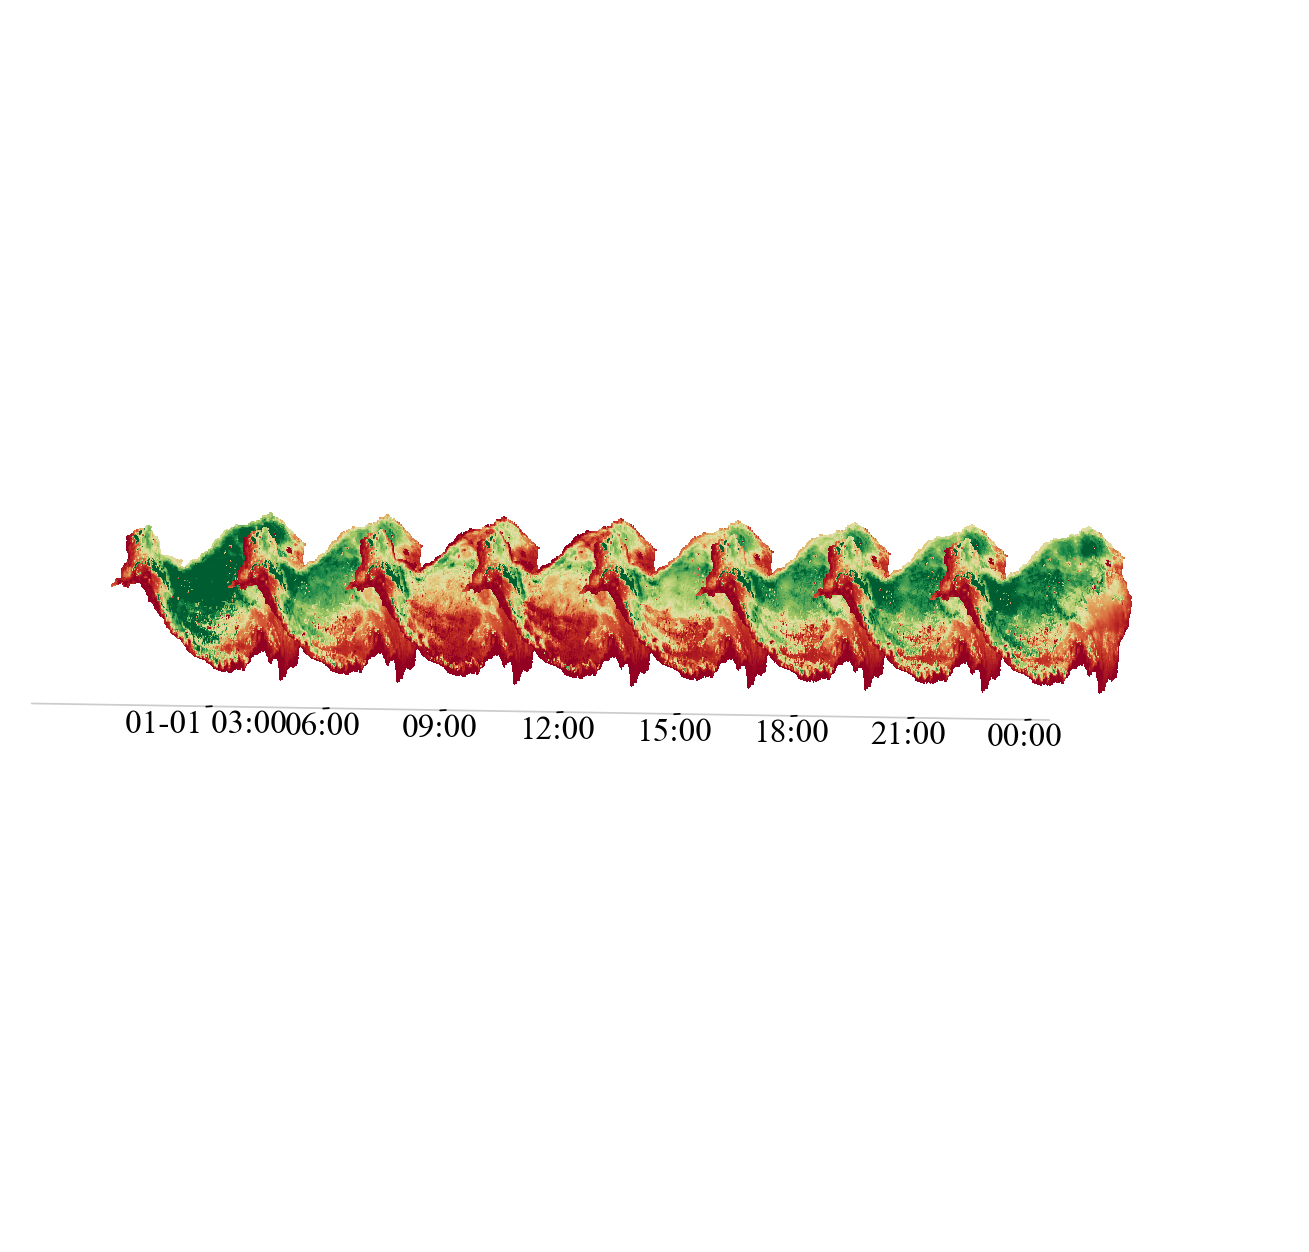

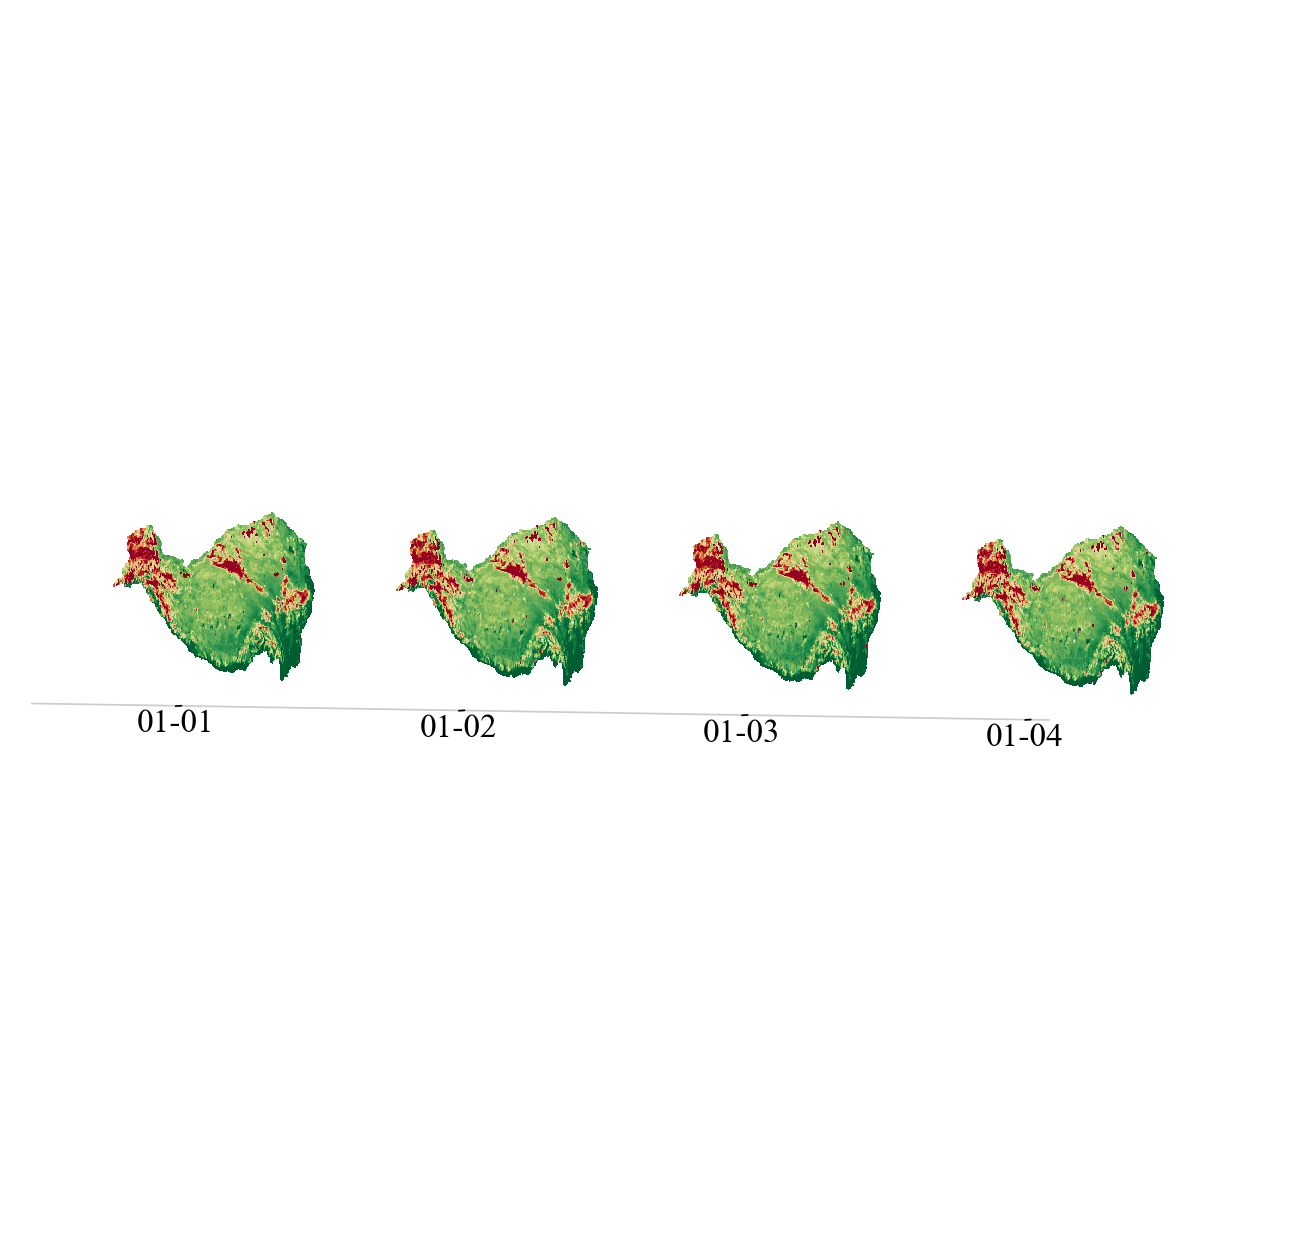

In [43]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib as mpl

def generate_clipping_mask(lon_grid, lat_grid, shp_path):
    """
    使用.shp文件生成数据掩码：在边界外的数据掩码为0，在边界内的数据掩码为1。
    """
    import geopandas as gpd
    from shapely.geometry import Point
    import numpy as np

    gdf = gpd.read_file(shp_path)
    poly = gdf.unary_union
    mask = np.zeros_like(lon_grid, dtype=bool)

    for i in range(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            point = Point(lon_grid[i, j], lat_grid[i, j])
            if point.within(poly):
                mask[i, j] = True

    return mask

# SHP地址
shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
data_path = r"D:\Data_Store\Dataset\Original_Data\0.1_Data.zarr"
data = xr.open_zarr(data_path)

# 提取 Hourly 数据
hourly_data = data.soil_temperature_level_1.isel(time=slice(None, 16)).values
hourly_index = pd.date_range(start='2016-1-1 03:00', periods=16, freq='3H')

# 提取 Daily 数据
daily_data = data.Albedo_BSA_Band1.isel(time=slice(None, 8)).values
daily_index = pd.date_range(start='2016-1-1 03:00', periods=8, freq='1D')

# 提取 Static 数据
static_data = data.NDVI.isel(time=slice(None, 3)).values
dem_static_data = data.as_dem_3s.isel(time=slice(None, 3)).values
static_index = pd.date_range(start='2016-1-1 03:00', periods=3, freq='16D')

settings = {0.1: (25.550117, 40.450184, 66.95031, 104.95048, 150, 381)}
masks = {}
for mode, (lat_min, lat_max, lon_min, lon_max, lat_points, lon_points) in settings.items():
    lon_step = (lon_max - lon_min) / (lon_points - 1)
    lat_step = (lat_max - lat_min) / (lat_points - 1)
    new_lon_min = lon_min - lon_step / 2
    new_lon_max = lon_max + lon_step / 2
    new_lat_min = lat_min - lat_step / 2
    new_lat_max = lat_max + lat_step / 2
    lon_range, lat_range = np.linspace(new_lon_min, new_lon_max, lon_points), np.linspace(new_lat_min, new_lat_max, lat_points)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    masks[mode] = generate_clipping_mask(lon_grid, lat_grid, shp_path)
mask = masks[0.1]
hourly_data = np.where(mask, hourly_data, np.nan)
daily_data = np.where(mask, daily_data, np.nan)
static_data = np.where(mask, static_data, np.nan)
dem_static_data = np.where(mask, dem_static_data, np.nan)

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)
def customize_ytick_labels(ax, time_positions, data_index,name=None):
    labels = []
    if name == 'hourly_data':
        for i, date in enumerate(data_index):
            if i == 0:
                labels.append(date.strftime('%m-%d %H:%M'))
            else:
                labels.append(date.strftime('%H:%M'))
        ax.set_yticks(time_positions+1)
    else:
        for i, date in enumerate(data_index):
            labels.append(date.strftime('%m-%d'))
        ax.set_yticks(time_positions+0.3)

    ax.set_yticklabels(labels, rotation=0, ha='right')

def plot_data_slices(data, data_index, lon_range, lat_range, name):
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(111, projection='3d')
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    time_positions = np.arange(data.shape[0])

    vmin = np.nanpercentile(data, 5)
    vmax = np.nanpercentile(data, 95)

    # 创建归一化和映射对象
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap='RdYlGn_r')

    # 绘制每个数据片
    for i in range(data.shape[0]):
        slice_data = data[i, :, :]
        colors = mappable.to_rgba(slice_data)
        colors[np.isnan(slice_data), -1] = 0  # 将NaN值的颜色设置为透明
        ax.plot_surface(lon_grid, np.full(lon_grid.shape, time_positions[i]), lat_grid,
                        facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False)

    customize_ytick_labels(ax, time_positions, data_index,name=name)
    ax.tick_params(axis='y', colors='black', length=4, width=1.5, labelsize=24, direction='inout', pad=0)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    # 隐藏x轴和z轴及其刻度标签
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='x', colors='none', length=0, width=0, labelsize=0, direction='out', pad=0)
    ax.tick_params(axis='z', colors='none', length=0, width=0, labelsize=0, direction='out', pad=0)
    # 隐藏x轴和z轴的网格线和面板
    ax.xaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.w_xaxis.line.set_visible(False)
    ax.w_zaxis.line.set_visible(False)

    #ax.set_axis_off()
    ax.set_proj_type('ortho')
    ax.set_box_aspect([3, 6, 1])
    ax.view_init(elev=2, azim=25)
    ax.grid(False)
    plt.savefig(r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_vars"+name+".png", dpi=150, format='png', bbox_inches='tight', transparent=True)
    plt.show()


plot_data_slices(hourly_data[0:8, :, ::-1], hourly_index[0:8], lon_range, lat_range ,name='hourly_data')
plot_data_slices(daily_data[0:4, :, ::-1], daily_index[0:4], lon_range, lat_range ,name='daily_data')
plot_data_slices(dem_static_data[0:1, :, ::-1], daily_index[0:1], lon_range, lat_range ,name='dem_data')

### 图片裁剪

In [60]:
from PIL import Image

def crop_image(input_path, output_path):
    img = Image.open(input_path)
    width, height = img.size
    
    # 计算裁剪参数
    left = width * 0.41  # 左边裁剪掉10%
    right =  width - left
    top = height // 2.6
    bottom = height - top  # 保持top和bottom的计算不变
    
    # 裁剪图像
    img_cropped = img.crop((left, top, right, bottom))
    img_cropped.save(output_path)

#input_paths = [r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varsdaily_data.png", r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varshourly_data.png"]
#output_paths = [r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varsdaily_data_cropped.png", r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varshourly_data_cropped.png"]
input_paths = [r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varsdem_data.png"]
output_paths = [r"C:\Users\Administrator\Desktop\Draw\3d_mult_hourly_varsdem_data_cropped.png"]
for input_path, output_path in zip(input_paths, output_paths):
    crop_image(input_path, output_path)

### 辅助变量-静态数据绘图

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib as mpl

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)

# SHP地址
shp_path = r"D:\\Data_Store\\TPBoundary_new(2021)\\TPBoundary_new(2021).shp"
lakes_path = r"D:\Data_Store\TPBoundary_new(2021)\Lake_TP_2010.shp"
tp_boundary = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)

# SMAP数据
SMAP_file_path = r"D:\Data_Store\Dataset\Reconstruction\37SM\soil_moisture.npy"
dates = pd.date_range(start='2016-01-01 03:00', periods=8768, freq='3H')
filter_mask = ((dates.hour == 6) | (dates.hour == 18))
filtered_indices = np.where(filter_mask)[0]
SMAP_data = np.load(SMAP_file_path)[filtered_indices, :, :]


nan_counts = np.isnan(SMAP_data).sum(axis=(0))
zero_counts = (SMAP_data == 0).sum(axis=(0))
total_pixels_per_time_step = SMAP_data.shape[0]
missing_rate = (nan_counts + zero_counts) / total_pixels_per_time_step

# 创建地图热力图
low_res_params = (25.293533, 40.604774, 66.84705, 105.31184, 42, 104)
num_lons = low_res_params[4]
num_lats = low_res_params[5]
lon_step = (low_res_params[3] - low_res_params[2]) / (num_lons - 1)
lat_step = (low_res_params[1] - low_res_params[0]) / (num_lats - 1)

lon_min_adj = low_res_params[2] - lon_step / 2
lon_max_adj = low_res_params[3] + lon_step / 2
lat_min_adj = low_res_params[0] - lat_step / 2
lat_max_adj = low_res_params[1] + lat_step / 2

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# 绘制地理空间数据
gdf = gpd.read_file(shp_path)
lakes = gpd.read_file(lakes_path)
polygons = [Path(np.array(shape.exterior.coords)) for shape in gdf.geometry]
path = Path.make_compound_path(*polygons)
patch = PathPatch(path, facecolor='none', edgecolor='none')
ax.add_patch(patch)
ax.set_clip_path(patch)

lakes = lakes.to_crs(epsg=4326)
lakes.plot(ax=ax, edgecolor='blue', facecolor='white', linewidth=0.2)
gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)


image = ax.imshow(missing_rate, cmap='YlGnBu', origin='lower', vmin=0, vmax=1, extent=[lon_min_adj, lon_max_adj, lat_min_adj, lat_max_adj], aspect='auto', clip_path=patch)



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.grid(False)

cbar_ax = fig.add_axes([0.98, 0.1, 0.03, 0.8])
cbar = fig.colorbar(image, cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Administrator\Desktop\Draw\SMAP_Miss_rate_darw.png", dpi=150, format='png', bbox_inches='tight', transparent=True)

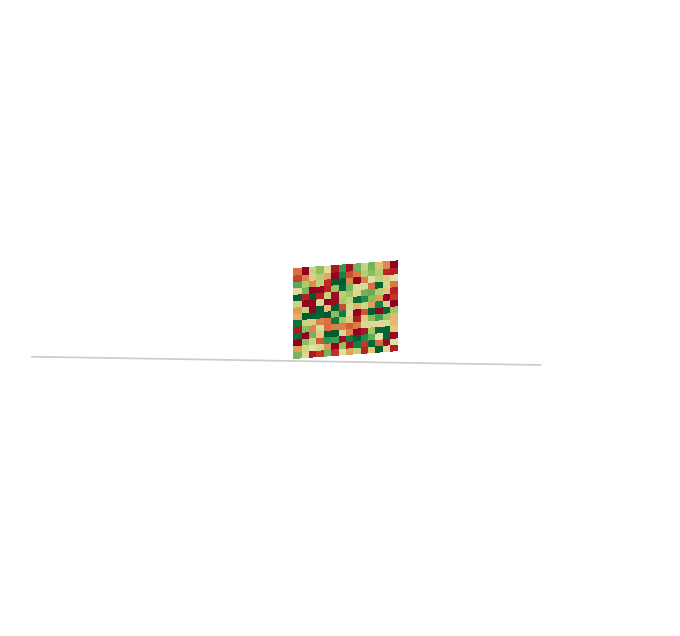

In [51]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib as mpl

sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)
sns.set(style="whitegrid", font='Times New Roman')
matplotlib.rcParams['font.family'] = 'Times New Roman'
legend_font = FontProperties(family='Times New Roman', size=18)
font_prop = FontProperties(family='Times New Roman', size=18)
def customize_ytick_labels(ax, time_positions, data_index):
    labels = []
    for i, date in enumerate(data_index):
        if i == 0:
            labels.append(date.strftime('%Y-%m-%d %H:%M'))
        else:
            labels.append(date.strftime('%H:%M'))
    ax.set_yticks(time_positions+1)
    ax.set_yticklabels(labels, rotation=0, ha='right')

def plot_data_slices(data, data_index, lon_range, lat_range, name):
    fig = plt.figure(figsize=(24, 8))
    ax = fig.add_subplot(111, projection='3d')
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    time_positions = np.arange(data.shape[0])

    vmin = np.nanpercentile(data, 5)
    vmax = np.nanpercentile(data, 95)

    # 创建归一化和映射对象
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap='RdYlGn_r')

    # 绘制每个数据片
    for i in range(data.shape[0]):
        slice_data = data[i, :, :]
        colors = mappable.to_rgba(slice_data)
        colors[np.isnan(slice_data), -1] = 0  # 将NaN值的颜色设置为透明
        ax.plot_surface(lon_grid, np.full(lon_grid.shape, time_positions[i]), lat_grid,
                        facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False)

    customize_ytick_labels(ax, time_positions, data_index)
    ax.tick_params(axis='y', colors='black', length=4, width=1.5, labelsize=18, direction='inout', pad=0)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    # 隐藏x轴和z轴及其刻度标签
    ax.set_xticklabels([])
    ax.set_zticklabels([])
    ax.tick_params(axis='x', colors='none', length=0, width=0, labelsize=0, direction='out', pad=0)
    ax.tick_params(axis='z', colors='none', length=0, width=0, labelsize=0, direction='out', pad=0)
    # 隐藏x轴和z轴的网格线和面板
    ax.xaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.w_xaxis.line.set_visible(False)
    ax.w_zaxis.line.set_visible(False)

    #ax.set_axis_off()
    ax.set_proj_type('ortho')
    ax.set_box_aspect([3, 6, 1])
    ax.view_init(elev=2, azim=25)
    ax.grid(False)
    plt.show()
settings = {0.1: (25.550117, 40.450184, 66.95031, 104.95048, 15, 15)}

# 初始化变量
lon_range, lat_range = None, None

# 使用设置生成lon_range和lat_range
for mode, (lat_min, lat_max, lon_min, lon_max, lat_points, lon_points) in settings.items():
    lon_step = (lon_max - lon_min) / (lon_points - 1)
    lat_step = (lat_max - lat_min) / (lat_points - 1)
    new_lon_min = lon_min - lon_step / 2
    new_lon_max = lon_max + lon_step / 2
    new_lat_min = lat_min - lat_step / 2
    new_lat_max = lat_max + lat_step / 2
    lon_range, lat_range = np.linspace(new_lon_min, new_lon_max, lon_points), np.linspace(new_lat_min, new_lat_max, lat_points)

hourly_data1 = np.random.rand(2, 15, 15)
hourly_index = pd.date_range(start='2016-1-1 03:00', periods=16, freq='3H')
plot_data_slices(hourly_data1[0:1], hourly_index[0:1], lon_range, lat_range ,name='hourly_data')

In [70]:
import xarray as xr
data_path = r"D:\Data_Store\Dataset\Original_Data\0.1_Data.zarr"
data = xr.open_zarr(data_path)
data

<xarray.Dataset>
Dimensions:                               (time: 8768, lat: 150, lon: 381)
Coordinates:
  * lat                                   (lat) float32 25.55 25.65 ... 40.45
  * lon                                   (lon) float32 66.95 67.05 ... 105.0
  * time                                  (time) datetime64[ns] 2016-01-01T03...
Data variables: (12/41)
    Albedo_BSA_Band1                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    Albedo_BSA_Band2                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    Albedo_BSA_Band3                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    Albedo_BSA_Band4                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    Albedo_BSA_Band5                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    Albedo_BSA_Band6                      (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    ...                                    ...
    soil_temperature_level_1              (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    surface_latent_heat_flux_hourly       (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    surface_net_solar_radiation_hourly    (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    surface_net_thermal_radiation_hourly  (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    surface_sensible_heat_flux_hourly     (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>
    total_evaporation_hourly              (time, lat, lon) float32 dask.array<chunksize=(548, 19, 48), meta=np.ndarray>